In [1]:
import cv2
import numpy as np
import mediapipe as mp
import math
from IPython.display import display, Image ,clear_output
import time
import keyboard
from transitions import Machine
from collections import deque

In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [3]:
def showVideo(img, fps=30):     
    _, en_image = cv2.imencode('.jpg',img)
    img_obj = Image(data = en_image)
    clear_output(True)
    display(img_obj)
    time.sleep(1/fps)
    if keyboard.is_pressed('esc'):
        video.release()

In [4]:
def calculateSpatialRelationship(p1, p2):  
    relationship = None
    if len(p1) == 2 & len(p2) == 2:
        if p1[1] < p2[1]:
            relationship = 'above'
        elif p1[1] > p2[1]:
            relationship = 'below'
   
    return relationship

In [5]:
def calculateSpatialRelationship2(p1, p2):
    relationship = None
    if len(p1) == 2 & len(p2) == 2:
        if p1[1] < p2[1]:
            relationship = 'back'
        elif p1[1] > p2[1]:
            relationship = 'front'

    return relationship

In [6]:
def findPosition(img):
    lmList = []
    if results.pose_landmarks:
        for id, lm in enumerate(results.pose_landmarks.landmark):
            h, w, c = img.shape
            cx, cy = int(lm.x * w), int(lm.y * h)
            lmList.append([id, cx, cy])
    return lmList

In [7]:
def caculateGesture(right_wrist_shoulder_sp_relation,left_wrist_shoulder_sp_relation,right_wrist_hip_sp_relation\
                                  ,left_wrist_hip_sp_relation,right_left_leg_sp_relation):
    gesture = 'unknown'
    if right_wrist_shoulder_sp_relation == 'above' and right_left_leg_sp_relation == 'back' and left_wrist_hip_sp_relation == 'below':
        gesture ='a'
    elif right_wrist_hip_sp_relation == 'below' and right_left_leg_sp_relation == 'front' and left_wrist_shoulder_sp_relation == 'above':
        gesture = 'b'  
    return gesture

In [8]:
def jumpState(dY_24,threshold = 5):
    """
    threshold:判斷up與down的閾值
    """
    jump_state = 'unknown'
    if dY_24 < -threshold:
        jump_state = 'up'
    elif dY_24 > threshold:
        jump_state = 'down'   
    return jump_state

In [9]:
class Action():
    
    states = ['UNKNOWN', 'A', 'B']
    
    def __init__(self):
        
        self.duration = 0
        self.prev_time = 0
        self.new_time = 0
        self.cycle_count = 0
        self.frame = 0
        
        self.machine = Machine(model = self, states =Action.states, initial = 'UNKNOWN', ignore_invalid_triggers = True)
        
        self.machine.add_transition(trigger = 'a', source = 'UNKNOWN', dest = 'A', after = 'logging')#1
        self.machine.add_transition(trigger = 'b', source = 'A', dest = 'B')#2
        
        self.machine.add_transition(trigger = 'unknown', source = 'B', dest = 'UNKNOWN', after = 'update_cycle_count')#3
        self.machine.add_transition(trigger = 'a', source = 'B', dest = 'UNKNOWN', after = 'update_cycle_count')#3
        self.machine.add_transition(trigger = 'b', source = 'B', dest = 'UNKNOWN', after = 'update_cycle_count')#3
                       
    def logging(self):
        self.prev_time = self.new_time
        self.new_time = self.frame
        if self.prev_time != 0:
            self.duration = self.new_time - self.prev_time
         
    def update_cycle_count(self):
        if self.duration == 0 or self.duration < 50:
            self.cycle_count += 1   

In [10]:
class Jump():
    
    states = ['INITIAL', 'UP', 'DOWN']
    
    def __init__(self):
        
        self.duration = 0
        self.prev_time = 0
        self.new_time = 0
        
        self.machine = Machine(model = self, states =Jump.states, initial = 'INITIAL', ignore_invalid_triggers = True)
        
        self.machine.add_transition(trigger = 'up', source = 'INITIAL', dest = 'UP', after = 'logging')#1
        self.machine.add_transition(trigger = 'down', source = 'UP', dest = 'DOWN')#2
        
        self.machine.add_transition(trigger = 'unknown', source = 'DOWN', dest = 'INITIAL')#3
        self.machine.add_transition(trigger = 'up', source = 'DOWN', dest = 'INITIAL')#3
        self.machine.add_transition(trigger = 'down', source = 'DOWN', dest = 'INITIAL')#3
                       
    def logging(self):
        self.prev_time = self.new_time
        self.new_time = time.time()
        if self.prev_time != 0:
            self.duration = self.new_time - self.prev_time

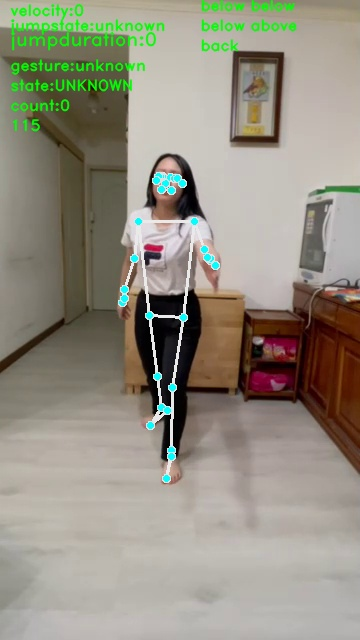

In [11]:
video = cv2.VideoCapture('../../video_data/(005)jumping_diff/NG3.MOV')

jump_detector = Jump()
action_detector = Action()
pose = mp_pose.Pose(model_complexity=2,smooth_landmarks=True,min_detection_confidence=0.5, min_tracking_confidence=0.5)
pts_24 = deque(maxlen=5)

counter = 0
while True:
    success, img = video.read()
    if not success:
        break
    if success:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
       
        dY_24= 0
        action_detector.frame = counter
        # 偵測landmarks
        results = pose.process(img)
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # 畫出landmarks
        mp_drawing.draw_landmarks(img, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(255,255,0), thickness=2, circle_radius=2),
                                mp_drawing.DrawingSpec(color=(233,233,233), thickness=2, circle_radius=2))
        # 存取keypoint座標 
        lmList = findPosition(img)
        #計算right_hip dx dy
        pts_24.appendleft((lmList[24][1],lmList[24][2]))             
        #loop over the set of tracked points
        for i in np.arange(1, len(pts_24)):
            # if either of the tracked points are None, ignore
            # them
            if pts_24[i - 1] is None or pts_24[i] is None:
                continue
            # check to see if enough points have been accumulated in
            # the buffer
            if counter >= 3 and i == 1 and pts_24[-3] is not None:
                # compute the difference between the x and y
                # coordinates and re-initialize the direction
                # text variables
                dX_24 = pts_24[-3][0] - pts_24[i][0]
                dY_24 = pts_24[i][1] - pts_24[-3][1]
        #                                
        right_wrist_shoulder_sp_relation = calculateSpatialRelationship((lmList[16][1],lmList[16][2]),(lmList[12][1],lmList[12][2]))
        left_wrist_shoulder_sp_relation = calculateSpatialRelationship((lmList[15][1],lmList[15][2]),(lmList[11][1],lmList[11][2]))
        
        right_wrist_hip_sp_relation = calculateSpatialRelationship((lmList[16][1],lmList[16][2]),(lmList[24][1],(lmList[24][2]+lmList[12][2])/2))
        left_wrist_hip_sp_relation = calculateSpatialRelationship((lmList[15][1],lmList[15][2]),(lmList[23][1],(lmList[23][2]+lmList[11][2])/2))
        
        right_left_leg_sp_relation = calculateSpatialRelationship2((lmList[28][1],lmList[28][2]),(lmList[27][1],lmList[27][2]))
        
        cv2.putText(img, str(right_wrist_shoulder_sp_relation), (200,10),cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
        cv2.putText(img, str(left_wrist_shoulder_sp_relation), (200,30),cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
        cv2.putText(img, str(right_wrist_hip_sp_relation), (250,10),cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
        cv2.putText(img, str(left_wrist_hip_sp_relation), (250,30),cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
        cv2.putText(img, str( right_left_leg_sp_relation), (200,50),cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)

                
                
        gesture = caculateGesture(right_wrist_shoulder_sp_relation,left_wrist_shoulder_sp_relation,right_wrist_hip_sp_relation\
                                  ,left_wrist_hip_sp_relation,right_left_leg_sp_relation)
        cv2.putText(img, 'gesture:'+str(gesture), (10,70),cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
        
        if gesture == 'a':
            action_detector.a()
        if gesture == 'b':
            action_detector.b()
        if gesture == 'unknown':
            action_detector.unknown()
                
        cv2.putText(img, "state:"+str(action_detector.state), (10,90),cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
        cv2.putText(img, "count:"+str(action_detector.cycle_count), (10,110),cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
        cv2.putText(img,str(action_detector.frame), (10,130),cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
        
        cv2.putText(img, "velocity:"+str(dY_24), (10,15),cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
        jump_state = jumpState(dY_24,threshold = 5)
        
        if jump_state == 'unknown':
            jump_detector.unknown()
        if jump_state == 'up':
            jump_detector.up()
        if jump_state == 'down':
            jump_detector.down()
            
        
        cv2.putText(img, "jumpstate:"+str(jump_state), (10,30),cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
        cv2.putText(img, "jumpduration:"+str(round(action_detector.duration,2)), (10,45),cv2.FONT_HERSHEY_DUPLEX, 0.6, (0, 255, 0), 1, cv2.LINE_AA)
#         cv2.putText(img,'state :'+str(action_detector.state), (10,80),cv2.FONT_HERSHEY_DUPLEX, 0.7, (0,  255, 0), 1, cv2.LINE_AA)
#         cv2.putText(img, ('count:'+str(action_detector.cycle_count)), (10,105), cv2.FONT_HERSHEY_DUPLEX, 0.7, (0,  255, 0), 1, cv2.LINE_AA)  
        
             
        showVideo(img,fps=30)
        
        counter += 1
video.release()